# Predict whether a customer is going to buy a product next month.

In this notebook we'll understand how to build a Machine Learning model to predict whether customers will make their next purchase after a certain period.

Suppose the managerial team of an online retail shop approaches you, a data scientist, with the dataset wanting to know whether customers will make their next purchase 90 days from the day they made their last purchase. Your answer to their inquiry will help them identify which customers their marketing team need to have a focus on with regard to the next promotional offers they will be rolling out.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# avoid displaying warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
#import plotly.offline as pyoff
import plotly.graph_objs as go 
#import plotly.figure_factory as ff
#AUC, confusion matrix

#import machine learning related libraries
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.cluster import KMeans
import xgboost as xgb
import time
from sklearn.metrics import classification_report,confusion_matrix


from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

In [2]:
data = pd.read_csv("../input/online-retail-dataset/Data.csv")

In [3]:
data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
944463,575312,22083,PAPER CHAIN KIT RETROSPOT,6,2011-11-09 12:49:00,2.95,13588.0,United Kingdom
944464,575312,23355,HOT WATER BOTTLE KEEP CALM,4,2011-11-09 12:49:00,4.95,13588.0,United Kingdom
944465,575312,22110,BIRD HOUSE HOT WATER BOTTLE,6,2011-11-09 12:49:00,2.55,13588.0,United Kingdom
944466,575312,22037,ROBOT BIRTHDAY CARD,12,2011-11-09 12:49:00,0.42,13588.0,United Kingdom


In [4]:
data.rename(columns={'Invoice':'InvoiceNo', 'Customer ID':'CustomerID', 'Price':'UnitPrice'}, inplace=True)
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944468 entries, 0 to 944467
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    944468 non-null  object 
 1   StockCode    944468 non-null  object 
 2   Description  940274 non-null  object 
 3   Quantity     944468 non-null  int64  
 4   InvoiceDate  944468 non-null  object 
 5   UnitPrice    944468 non-null  float64
 6   CustomerID   732567 non-null  float64
 7   Country      944468 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 57.6+ MB


we can see that the CustomerID and Description columns are likely to have missing values. Also we may want to change the data type of the objects in the InvoiceDate column to proper date objects with the to_datetime method.

Let's count the number of missing values in each column of the dataframe.

In [6]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      4194
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     211901
Country             0
dtype: int64

As predicted, the columns CustomerID and Description have 211901 and 4194 missing data respectively.

In [7]:
np.round(data.isnull().sum()["CustomerID"]/data.InvoiceNo.shape[0] * 100, 2)

22.44

The missing data in the CustomerID column represents 22.44% of the entire online customers.

How do we deal with these missing data?  

The item that has a missing CustomerID should be deleted. One can achieve this with the dropna method.

In [8]:
df_data = data.dropna()
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 732567 entries, 0 to 944467
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    732567 non-null  object 
 1   StockCode    732567 non-null  object 
 2   Description  732567 non-null  object 
 3   Quantity     732567 non-null  int64  
 4   InvoiceDate  732567 non-null  object 
 5   UnitPrice    732567 non-null  float64
 6   CustomerID   732567 non-null  float64
 7   Country      732567 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 50.3+ MB


Next, we update the dataframe df_data by converting the date field, InvoiceDate to datetime object. One can use the to_datetime method to achieve this.

In [9]:
df_data.InvoiceDate = pd.to_datetime(df_data.InvoiceDate)
df_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [10]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,944468.000000,944468.000000,732567.000000
mean,10.220727,4.649261,15313.607487
std,139.363557,125.813579,1694.646055
min,-74215.000000,-53594.360000,12346.000000
25%,1.000000,1.250000,13952.000000
50%,3.000000,2.100000,15242.000000
75%,11.000000,4.150000,16784.000000
max,74215.000000,38970.000000,18287.000000


### 1. How many online customers are there in the dataset and what is their country of origin?

In [11]:
print('From the dataset, the online retail shop has {} customers \
from {} different countries.'.format(len(df_data.CustomerID.unique()), len(df_data.Country.unique())))

From the dataset, the online retail shop has 5780 customers from 41 different countries.


### 2. What are the countries that are most represented in the dataset?

In [12]:
ctm_cntry_df = df_data.groupby(['CustomerID', 'Country']).count().reset_index()

ctm_cntry_df = ctm_cntry_df.groupby('Country')['CustomerID'].count().reset_index().sort_values(
    by=['CustomerID'], ascending=False)

# Create a new column, Percentage to calculate the customer representation in percentage
ctm_cntry_df['Percentage']= np.round(ctm_cntry_df.CustomerID / ctm_cntry_df.CustomerID.sum() * 100, 2)

ctm_cntry_df.head(10)

,Country,CustomerID,Percentage
38,United Kingdom,5268,90.94
14,Germany,102,1.76
13,France,89,1.54
32,Spain,40,0.69
3,Belgium,29,0.50
24,Netherlands,23,0.40
28,Portugal,22,0.38
34,Switzerland,21,0.36
33,Sweden,19,0.33
18,Italy,16,0.28


The output above, shows the top  countries of that purchase from the online retail shop with the United Kingdom being the country with the highest customers. They represent about **90.94%** of the entire online customers.

In [13]:
# Initialise a dict object. This is supposed to collect all customers who indicated more than 1 country
ctm_2_cntry = {} 

# for each index and customer id
for idx, cid in enumerate(df_data.CustomerID.unique()):
    
    # Get the country that the customer resides
    cntry = df_data[df_data.CustomerID == cid].Country.unique()
    
    # if customer has lived in more than 1 country
    if len(cntry) > 1: 
        
        # Update the ctm_2_cntry
        ctm_2_cntry[cid] = cntry

pd.DataFrame(ctm_2_cntry) # Create a pandas dataframe using ctm_2_cntry

,12417.0,12455.0,12422.0,12431.0,12745.0,12370.0,12429.0,12423.0,12449.0,12457.0,12652.0,12413.0,12394.0
0,Belgium,Cyprus,Australia,Belgium,EIRE,Austria,Denmark,Denmark,Denmark,Switzerland,Germany,Spain,Belgium
1,Spain,Spain,Switzerland,Australia,United Kingdom,Cyprus,Austria,Belgium,Belgium,Cyprus,France,France,Denmark


In [14]:
percent_margin = 0.25

# Create a new column, CountryCategory and set values to the corresponding values of the Country column
ctm_cntry_df['CountryCategory'] = ctm_cntry_df.Country

# Set Countries with Percentage less than or equal to percent_margin to 'Other Countries'

ctm_cntry_df.loc[ctm_cntry_df.Percentage <= percent_margin, 'CountryCategory'] = 'Other Countries'

ctm_cntry_df.head(11)

,Country,CustomerID,Percentage,CountryCategory
38,United Kingdom,5268,90.94,United Kingdom
14,Germany,102,1.76,Germany
13,France,89,1.54,France
32,Spain,40,0.69,Spain
3,Belgium,29,0.50,Belgium
24,Netherlands,23,0.40,Netherlands
28,Portugal,22,0.38,Portugal
34,Switzerland,21,0.36,Switzerland
33,Sweden,19,0.33,Sweden
18,Italy,16,0.28,Italy


In [15]:
# plot pie chart

pie_fig = px.pie(ctm_cntry_df, 
                 names="CountryCategory", 
                 values="Percentage", 
                 title="Customer Country Count in Percentage"
                )

pie_fig.update_layout(title_x=0, 
                      legend_title="Countries Represented", 
                      legend=dict(orientation="h")
                     )

pie_fig.show(config={'displaylogo': False})

### 3. Calculate the revenue that was made in each month and what is the percentage revenue based on countries?

In [16]:
df_data['InvoiceYearMonth'] = df_data['InvoiceDate'].map(lambda date: 100*date.year + date.month)
df_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,200912
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,200912
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,200912
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,200912
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,200912


In [17]:
df_data['Revenue'] = df_data.UnitPrice * df_data.Quantity
df_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,200912,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,200912,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,200912,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,200912,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,200912,30.0


In [18]:
ctm_revenue = df_data.groupby('InvoiceYearMonth').Revenue.sum().reset_index()
ctm_revenue.head()

,InvoiceYearMonth,Revenue
0,200912,660125.100
1,201001,530436.512
2,201002,487596.426
3,201003,633419.311
4,201004,558007.832


In [19]:
pd.DataFrame(ctm_revenue.Revenue.describe())

,Revenue
count,2.400000e+01
mean,6.307889e+05
std,1.928468e+05
min,3.173142e+05
25%,5.468888e+05
50%,5.758443e+05
75%,6.502900e+05
max,1.129025e+06


In [20]:
# plot line plot
line_fig = px.line(ctm_revenue, 
                   x = "InvoiceYearMonth", 
                   y = "Revenue", 
                   title = "Montly Revenue from Dec. 2009 to Dec. 2011"
                  )

line_fig.update_layout(title_x=0.5, 
                       showlegend=False, 
                       xaxis={"type": "category"}, 
                       xaxis_title="Invoice Year-Month", 
                       yaxis_title="Monthly Revenue"
                      )

line_fig.show(config={'displaylogo': False})

From the graph figure above, we observe that the online retail shop made the highest sales in November 2010, followed by November 2011. Also, one can observe that, monthly sales rises after August.


Next, explore the percentage revenue generated by the retail shop based on the countries their customers reside.

In [21]:
cntry_revenue_df = df_data.groupby(['Country']).Revenue.sum().reset_index().sort_values(by=['Revenue'], 
                                                                                        ascending=False)

cntry_revenue_df['Percentage'] = np.round(cntry_revenue_df.Revenue / cntry_revenue_df.Revenue.sum() * 100, 2)

cntry_revenue_df.head(5)

,Country,Revenue,Percentage
38,United Kingdom,1.251781e+07,82.69
10,EIRE,5.404355e+05,3.57
24,Netherlands,5.152336e+05,3.40
14,Germany,3.805780e+05,2.51
13,France,2.892641e+05,1.91


From the output above, the top  countries with respect to revenue generated are:

* The United Kingdom
* The Republic of Ireland (EIRE)
* The Netherlands
* Germany
* France

with the United Kingdom recording the highest in percentage **82.69%**

In the next two cells, we update cntry_revenue_df with a new

In the two next cells, we group countries with revenue percentage value less than or equal to 0.25 together and then plot a pie chart.

In [22]:
percent_margin = 0.25

# Create a new column, CountryCategory and set values to the corresponding values of the Country column
cntry_revenue_df['CountryCategory'] = cntry_revenue_df.Country

# Set Countries with Percentage less than or equal to percent_margin to 'Other Countries'

cntry_revenue_df.loc[cntry_revenue_df.Percentage <= percent_margin, 'CountryCategory'] = 'Other Countries'

cntry_revenue_df.head(11)

,Country,Revenue,Percentage,CountryCategory
38,United Kingdom,1.251781e+07,82.69,United Kingdom
10,EIRE,5.404355e+05,3.57,EIRE
24,Netherlands,5.152336e+05,3.40,Netherlands
14,Germany,3.805780e+05,2.51,Germany
13,France,2.892641e+05,1.91,France
0,Australia,1.608026e+05,1.06,Australia
34,Switzerland,9.687012e+04,0.64,Switzerland
33,Sweden,8.545965e+04,0.56,Sweden
32,Spain,8.390503e+04,0.55,Spain
9,Denmark,6.159112e+04,0.41,Denmark


In [23]:
# plot pie chart
pie_fig = px.pie(cntry_revenue_df, 
                 names="CountryCategory", 
                 values="Percentage", 
                 title="Country Revenue in Percentage"
                )

pie_fig.update_layout(title_x=0, 
                      legend_title="Countries Represented", 
                      legend=dict(orientation="h")
                     )

pie_fig.show(config={'displaylogo': False})

### Predicting Customer Purchase

The goal of this section is to come up with a make a model using the given dataframe df_data, to estimate if a given customer will buy something again from the online shop in the next quarter.

The dataframe is split into two:

* The first sub-dataframe assigned to the Python variable ctm_bhvr_dt contains purchases made by customers from 01-12-2009 to 30-08-2011. This dataframe will be used to study the behavioural purchases of the online customers.


* The second sub-dataframe assigned to the Python variable ctm_next_quarter will be used to study the behavioural purchases of the customers in the next quarter. That is, from 01-09-2011 to 30-11-2011.

In [24]:
df_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,200912,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,200912,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,200912,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,200912,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,200912,30.0


In [25]:
ctm_bhvr_dt = df_data[(df_data.InvoiceDate < pd.Timestamp(2011,9,1)) & 
      (df_data.InvoiceDate >= pd.Timestamp(2009,12,1))].reset_index(drop=True)


ctm_next_quarter = df_data[(df_data.InvoiceDate < pd.Timestamp(2011,12,1)) & 
      (df_data.InvoiceDate >= pd.Timestamp(2011,9,1))].reset_index(drop=True)

In [26]:
# Get the distinct customers in the dataframe ctm_bhvr_dt
ctm_dt = pd.DataFrame(ctm_bhvr_dt['CustomerID'].unique())

# Rename the column to CustomerID.
ctm_dt.columns = ['CustomerID']

ctm_dt.head()

,CustomerID
0,13085.0
1,13078.0
2,15362.0
3,18102.0
4,12682.0


Let's find the first purchase made by each customer in the next quarter.

In [27]:
# Create a dataframe with CustomerID and customers first purchase 
# date in ctm_next_quarter
ctm_1st_purchase_in_next_quarter = ctm_next_quarter.groupby('CustomerID').InvoiceDate.min().reset_index()
ctm_1st_purchase_in_next_quarter.columns = ['CustomerID','MinPurchaseDate']
ctm_1st_purchase_in_next_quarter.head()

,CustomerID,MinPurchaseDate
0,12347.0,2011-10-31 12:25:00
1,12348.0,2011-09-25 13:13:00
2,12352.0,2011-09-20 14:34:00
3,12357.0,2011-11-06 16:07:00
4,12359.0,2011-10-13 12:47:00


Let's find the last purchase made by each customer in the dataframe ctm_bhvr_dt.

In [28]:
ctm_last_purchase_bhvr_dt = ctm_bhvr_dt.groupby('CustomerID').InvoiceDate.max().reset_index()
ctm_last_purchase_bhvr_dt.columns = ['CustomerID','MaxPurchaseDate']
ctm_last_purchase_bhvr_dt.head()

,CustomerID,MaxPurchaseDate
0,12346.0,2011-01-18 10:17:00
1,12347.0,2011-08-02 08:48:00
2,12348.0,2011-04-05 10:47:00
3,12349.0,2010-10-28 08:23:00
4,12350.0,2011-02-02 16:01:00


Let's merge the two dataframes ctm_last_purchase_bhvr_dt and ctm_1st_purchase_in_next_quarter.

In [29]:
# Merge two dataframes ctm_last_purchase_bhvr_dt and ctm_1st_purchase_in_next_quarter
ctm_purchase_dates = pd.merge(ctm_last_purchase_bhvr_dt, ctm_1st_purchase_in_next_quarter, on='CustomerID', 
                              how='left')
ctm_purchase_dates.head()

,CustomerID,MaxPurchaseDate,MinPurchaseDate
0,12346.0,2011-01-18 10:17:00,NaT
1,12347.0,2011-08-02 08:48:00,2011-10-31 12:25:00
2,12348.0,2011-04-05 10:47:00,2011-09-25 13:13:00
3,12349.0,2010-10-28 08:23:00,NaT
4,12350.0,2011-02-02 16:01:00,NaT


Let's calculate the time difference in days between customer's last purchase in the dataframe ctm_last_purchase_bhvr_dt and the first purchase in the dataframe ctm_1st_purchase_in_next_quarter.

In [30]:
ctm_purchase_dates['NextPurchaseDay'] = (ctm_purchase_dates['MinPurchaseDate'] - ctm_purchase_dates['MaxPurchaseDate']).dt.days

ctm_purchase_dates.head()

,CustomerID,MaxPurchaseDate,MinPurchaseDate,NextPurchaseDay
0,12346.0,2011-01-18 10:17:00,NaT,NaN
1,12347.0,2011-08-02 08:48:00,2011-10-31 12:25:00,90.0
2,12348.0,2011-04-05 10:47:00,2011-09-25 13:13:00,173.0
3,12349.0,2010-10-28 08:23:00,NaT,NaN
4,12350.0,2011-02-02 16:01:00,NaT,NaN


In [31]:
# merge with ctm_dt 
ctm_dt = pd.merge(ctm_dt, ctm_purchase_dates[['CustomerID','NextPurchaseDay']], on='CustomerID', how='left')
ctm_dt.head()

,CustomerID,NextPurchaseDay
0,13085.0,NaN
1,13078.0,13.0
2,15362.0,NaN
3,18102.0,27.0
4,12682.0,15.0


Update the dataframe ctm_dt by filling all missing values with 9999

In [32]:
ctm_dt = ctm_dt.fillna(9999)
ctm_dt.head()

,CustomerID,NextPurchaseDay
0,13085.0,9999.0
1,13078.0,13.0
2,15362.0,9999.0
3,18102.0,27.0
4,12682.0,15.0


Next, we will define some features and add them to the dataframe ctm_dt to build our machine learning model. We will use the Recency - Frequency - Monetary Value segmentation method. That is, we will put the customers into groups based on the following:

* Recency: Customers purchase behaviour based on their most recent purchase date and how many days they have been inactive since their last purchase.


* Frequency: Customers purchase behaviour based on the number of times they buy from the online retail shop.


* Monetary Value/Revenue: Customers purchase behaviour based the revenue they generate.

After we will apply K-means clustering to assign customers a score to each of the features.

**Recency**

Let's find the most recent purchase date of each customer and see how many days they have been inactive. Afterwards, we can apply K-means clustering to assign customers a recency score.

In [33]:
ctm_max_purchase = ctm_bhvr_dt.groupby('CustomerID').InvoiceDate.max().reset_index()
ctm_max_purchase.columns = ['CustomerID','MaxPurchaseDate']
ctm_max_purchase.head()

,CustomerID,MaxPurchaseDate
0,12346.0,2011-01-18 10:17:00
1,12347.0,2011-08-02 08:48:00
2,12348.0,2011-04-05 10:47:00
3,12349.0,2010-10-28 08:23:00
4,12350.0,2011-02-02 16:01:00


In [34]:
# Find the recency in days 
ctm_max_purchase['Recency'] = (ctm_max_purchase['MaxPurchaseDate'].max() - ctm_max_purchase['MaxPurchaseDate']).dt.days

# Merge the dataframes ctm_dt and ctm_max_purchase[['CustomerID', 'Recency']] on the CustomerID column.
ctm_dt = pd.merge(ctm_dt, ctm_max_purchase[['CustomerID', 'Recency']], on='CustomerID')
ctm_dt.head()

,CustomerID,NextPurchaseDay,Recency
0,13085.0,9999.0,57
1,13078.0,13.0,0
2,15362.0,9999.0,348
3,18102.0,27.0,26
4,12682.0,15.0,0


In [35]:
pd.DataFrame(ctm_dt.Recency.describe())

,Recency
count,5314.000000
mean,204.675574
std,173.569622
min,0.000000
25%,48.000000
50%,161.000000
75%,320.000000
max,638.000000


The mean Recency is approximately 205 days whiles the median is 161 days.

In [36]:
# plot histogram
hist_fig = px.histogram(ctm_dt, 
                        x="Recency", 
                        title="Customers Recency in Days"                       )

hist_fig.update_layout(title_x=0.5, 
                       xaxis_title="Recency in groups of 20 days", 
                       yaxis_title="Number of Customers"
                      )

hist_fig.show(config={'displaylogo': False})

Next we will apply K-means clustering to assign a recency score. However, we need to know how many clusters in order to use the K-means algorithm. We will apply Elbow Method to determine how many clusters we will need. The Elbow Method simply tells the optimal cluster number for optimal inertia.

In [37]:
my_dict={}
ctm_recency = ctm_dt[['Recency']]
for idx in range(1, 10):
    kmeans = KMeans(n_clusters=idx, max_iter=1000).fit(ctm_recency)
    ctm_recency["clusters"] = kmeans.labels_
    my_dict[idx] = kmeans.inertia_ 

line_fig = px.line(x=list(my_dict.keys()), 
                   y=list(my_dict.values()), 
                   template="plotly_dark"
                  )

line_fig.update_layout(title_x=0, 
                       xaxis_title="Number of cluster", 
                       yaxis_title=""
                      )

line_fig.show(config={'displaylogo': False})


From the Figure above,  seem to be the optimal one.

In [38]:
number_of_clusters = 4
kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.fit(ctm_dt[['Recency']])
ctm_dt['RecencyCluster'] = kmeans.predict(ctm_dt[['Recency']])
ctm_dt.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster
0,13085.0,9999.0,57,0
1,13078.0,13.0,0,0
2,15362.0,9999.0,348,1
3,18102.0,27.0,26,0
4,12682.0,15.0,0,0


In [39]:
def order_cluster(df, target_field_name, cluster_field_name, ascending):
    """
    INPUT:
        - df                  - pandas DataFrame
        - target_field_name   - str - A column in the pandas DataFrame df
        - cluster_field_name  - str - Expected to be a column in the pandas DataFrame df
        - ascending           - Boolean
        
    OUTPUT:
        - df_final            - pandas DataFrame with target_field_name and cluster_field_name as columns
    
    """
    # Add the string "new_" to cluster_field_name
    new_cluster_field_name = "new_" + cluster_field_name
    
    # Create a new dataframe by grouping the input dataframe by cluster_field_name and extract target_field_name 
    # and find the mean
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    
    # Sort the new dataframe df_new, by target_field_name in descending order
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    
    # Create a new column in df_new with column name index and assign it values to df_new.index
    df_new["index"] = df_new.index
    
    # Create a new dataframe by merging input dataframe df and part of the columns of df_new based on 
    # cluster_field_name
    df_final = pd.merge(df, df_new[[cluster_field_name, "index"]], on=cluster_field_name)
    
    # Update the dataframe df_final by deleting the column cluster_field_name
    df_final = df_final.drop([cluster_field_name], axis=1)
    
    # Rename the column index to cluster_field_name
    df_final = df_final.rename(columns={"index": cluster_field_name})
    
    return df_final

In [40]:
ctm_dt = order_cluster(ctm_dt, 'Recency', 'RecencyCluster', False)
ctm_dt.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster
0,13085.0,9999.0,57,3
1,13078.0,13.0,0,3
2,18102.0,27.0,26,3
3,12682.0,15.0,0,3
4,18087.0,46.0,44,3


In [41]:
#print cluster characteristics
ctm_dt.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,746.0,521.058981,64.958173,419.0,467.25,517.0,572.0,638.0
1,1423.0,315.092059,41.127986,237.0,282.00,308.0,339.0,418.0
2,1098.0,156.793260,39.442538,98.0,119.00,154.0,188.0,236.0
3,2047.0,38.300440,27.999147,0.0,13.00,33.0,61.0,97.0



Observe from the above that, 3 covers the most recent customers whereas 0 has the most inactive customers.

**Frequency**

Next, we will find customers purchase behaviour based on the number of times they buy from the online retail shop. That is, the total number of orders by each customer.

In [42]:
#get order counts for each user and create a dataframe with it
ctm_frequency = df_data.groupby('CustomerID').InvoiceDate.count().reset_index()
ctm_frequency.columns = ['CustomerID','Frequency']

In [43]:
#add this data to our main ctm_dt
ctm_dt = pd.merge(ctm_dt, ctm_frequency, on='CustomerID')

ctm_dt.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency
0,13085.0,9999.0,57,3,92
1,13078.0,13.0,0,3,801
2,18102.0,27.0,26,3,1026
3,12682.0,15.0,0,3,901
4,18087.0,46.0,44,3,95


In [44]:
pd.DataFrame(ctm_dt.Frequency.describe())

,Frequency
count,5314.000000
mean,134.508656
std,329.625858
min,1.000000
25%,21.000000
50%,54.000000
75%,140.750000
max,11217.000000


In [45]:
kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.fit(ctm_dt[['Frequency']])
ctm_dt['FrequencyCluster'] = kmeans.predict(ctm_dt[['Frequency']])

In [46]:
ctm_dt = order_cluster(ctm_dt, 'Frequency', 'FrequencyCluster', False)
ctm_dt.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster
0,13085.0,9999.0,57,3,92,3
1,18087.0,46.0,44,3,95,3
2,17519.0,9999.0,33,3,190,3
3,12362.0,40.0,12,3,242,3
4,15712.0,38.0,9,3,156,3


In [47]:
#see details of each cluster
ctm_dt.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,2.0,10768.500000,634.274783,10320.0,10544.25,10768.5,10992.75,11217.0
1,14.0,3367.714286,1153.137621,2283.0,2616.75,2775.5,3938.25,6167.0
2,444.0,619.074324,287.459121,350.0,405.00,519.0,738.50,1951.0
3,4854.0,76.478162,78.448629,1.0,19.00,47.0,108.00,349.0


As it was for the case of the Recency, higher frequency number means better customers.

**Revenue**

In [48]:
ctm_revenue = df_data.groupby('CustomerID').Revenue.sum().reset_index()

In [49]:
#merge it with our ctm_dt
ctm_dt = pd.merge(ctm_dt, ctm_revenue, on='CustomerID')
ctm_dt.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,13085.0,9999.0,57,3,92,3,1459.46
1,18087.0,46.0,44,3,95,3,14411.62
2,17519.0,9999.0,33,3,190,3,4411.48
3,12362.0,40.0,12,3,242,3,4804.39
4,15712.0,38.0,9,3,156,3,3261.01


In [50]:
#apply clustering
kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.fit(ctm_dt[['Revenue']])
ctm_dt['RevenueCluster'] = kmeans.predict(ctm_dt[['Revenue']])

In [51]:
#order the cluster numbers
ctm_dt = order_cluster(ctm_dt, 'Revenue', 'RevenueCluster', True)
ctm_dt.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,13085.0,9999.0,57,3,92,3,1459.46,0
1,18087.0,46.0,44,3,95,3,14411.62,0
2,17519.0,9999.0,33,3,190,3,4411.48,0
3,12362.0,40.0,12,3,242,3,4804.39,0
4,15712.0,38.0,9,3,156,3,3261.01,0


In [52]:
#show details of the dataframe
ctm_dt.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,5249.0,1900.505185,2979.799132,-25111.09,321.8800,844.20,2144.4500,23090.47
1,56.0,44956.108089,23461.188687,23877.75,27918.0225,34671.50,53414.2975,117395.32
2,7.0,193148.992857,57169.250333,134907.47,147547.1850,182233.46,225031.6050,289744.44
3,2.0,524667.270000,48000.840754,490725.55,507696.4100,524667.27,541638.1300,558608.99


**Overall Score**

Finally we sum all the cluster features

In [53]:
#calculate overall score and use mean() to see details
ctm_dt['OverallScore'] = ctm_dt['RecencyCluster'] + ctm_dt['FrequencyCluster'] + ctm_dt['RevenueCluster']
ctm_dt.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
2,451.000000,362.000000,2726.520000
3,515.888305,35.002628,382.007769
4,309.204795,85.593836,1128.470051
5,125.052933,240.129471,3622.898364
6,40.652330,128.049582,3240.926875
7,13.842105,617.421053,100259.897895
8,26.000000,1026.000000,558608.990000


The scoring above clearly shows us that customers with score

In [54]:
ctm_dt['Segment'] = 'Low-Value'
ctm_dt.loc[ctm_dt['OverallScore'] > 4, 'Segment'] = 'Mid-Value'
ctm_dt.loc[ctm_dt['OverallScore'] > 6, 'Segment'] = 'High-Value'

In [55]:
ctm_dt.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,13085.0,9999.0,57,3,92,3,1459.46,0,6,Mid-Value
1,18087.0,46.0,44,3,95,3,14411.62,0,6,Mid-Value
2,17519.0,9999.0,33,3,190,3,4411.48,0,6,Mid-Value
3,12362.0,40.0,12,3,242,3,4804.39,0,6,Mid-Value
4,15712.0,38.0,9,3,156,3,3261.01,0,6,Mid-Value


Let us create a copy of the dataframe ctm_dt and apply the method get_dummies to it so as to convert all categorical column Segment to indicator variables.

In [56]:
#create ctm_class as a copy of ctm_dt before applying get_dummies
ctm_class = ctm_dt.copy()
ctm_class = pd.get_dummies(ctm_class)
ctm_class.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,13085.0,9999.0,57,3,92,3,1459.46,0,6,0,0,1
1,18087.0,46.0,44,3,95,3,14411.62,0,6,0,0,1
2,17519.0,9999.0,33,3,190,3,4411.48,0,6,0,0,1
3,12362.0,40.0,12,3,242,3,4804.39,0,6,0,0,1
4,15712.0,38.0,9,3,156,3,3261.01,0,6,0,0,1


Since our goal is to estimate whether a customer will make a purchase in the next quarter, we will create a new column NextPurchaseDayRange with values as either 1 or 0 defined as follows:

* If the value is 1, then it indicates that the customer will buy something in the next quarter, i.e., 90 days from his or her last purchase.

* The value 0 indicates that the customer will buy something in more than 90 days from his or her last purchase.

In [57]:
ctm_class['NextPurchaseDayRange'] = 1  ## less than 3 months
ctm_class.loc[ctm_class.NextPurchaseDay>90,'NextPurchaseDayRange'] = 0 # more than 3 months
ctm_class.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value,NextPurchaseDayRange
0,13085.0,9999.0,57,3,92,3,1459.46,0,6,0,0,1,0
1,18087.0,46.0,44,3,95,3,14411.62,0,6,0,0,1,1
2,17519.0,9999.0,33,3,190,3,4411.48,0,6,0,0,1,0
3,12362.0,40.0,12,3,242,3,4804.39,0,6,0,0,1,1
4,15712.0,38.0,9,3,156,3,3261.01,0,6,0,0,1,1


Finally in this section, let's see the correlation between our features and label. We can achieve this by applying the corr method to the dataframe ctm_dt.

In [58]:
corr_matrix = ctm_class[ctm_class.columns].corr()
corr_df = pd.DataFrame(corr_matrix.min())
corr_df.columns = ['MinCorrelationCoeff']
corr_df['MaxCorrelationCoeff'] = corr_matrix[corr_matrix < 1].max()
corr_df

,MinCorrelationCoeff,MaxCorrelationCoeff
CustomerID,-0.044171,0.042228
NextPurchaseDay,-0.638385,0.430140
Recency,-0.964760,0.856637
RecencyCluster,-0.964760,0.965560
Frequency,-0.705590,0.484804
FrequencyCluster,-0.705590,0.293458
Revenue,-0.364364,0.811609
RevenueCluster,-0.338742,0.811609
OverallScore,-0.930400,0.965560
Segment_High-Value,-0.083032,0.640359


From the output above, we observe that Overall Score has the highest positive correlation of 0.97 with RecencyCluster and Segment_Low-Value has the highest negative of -0.99 with Segment_Mid-Value.

We can get a good visualisation of the coefficient matrix below.

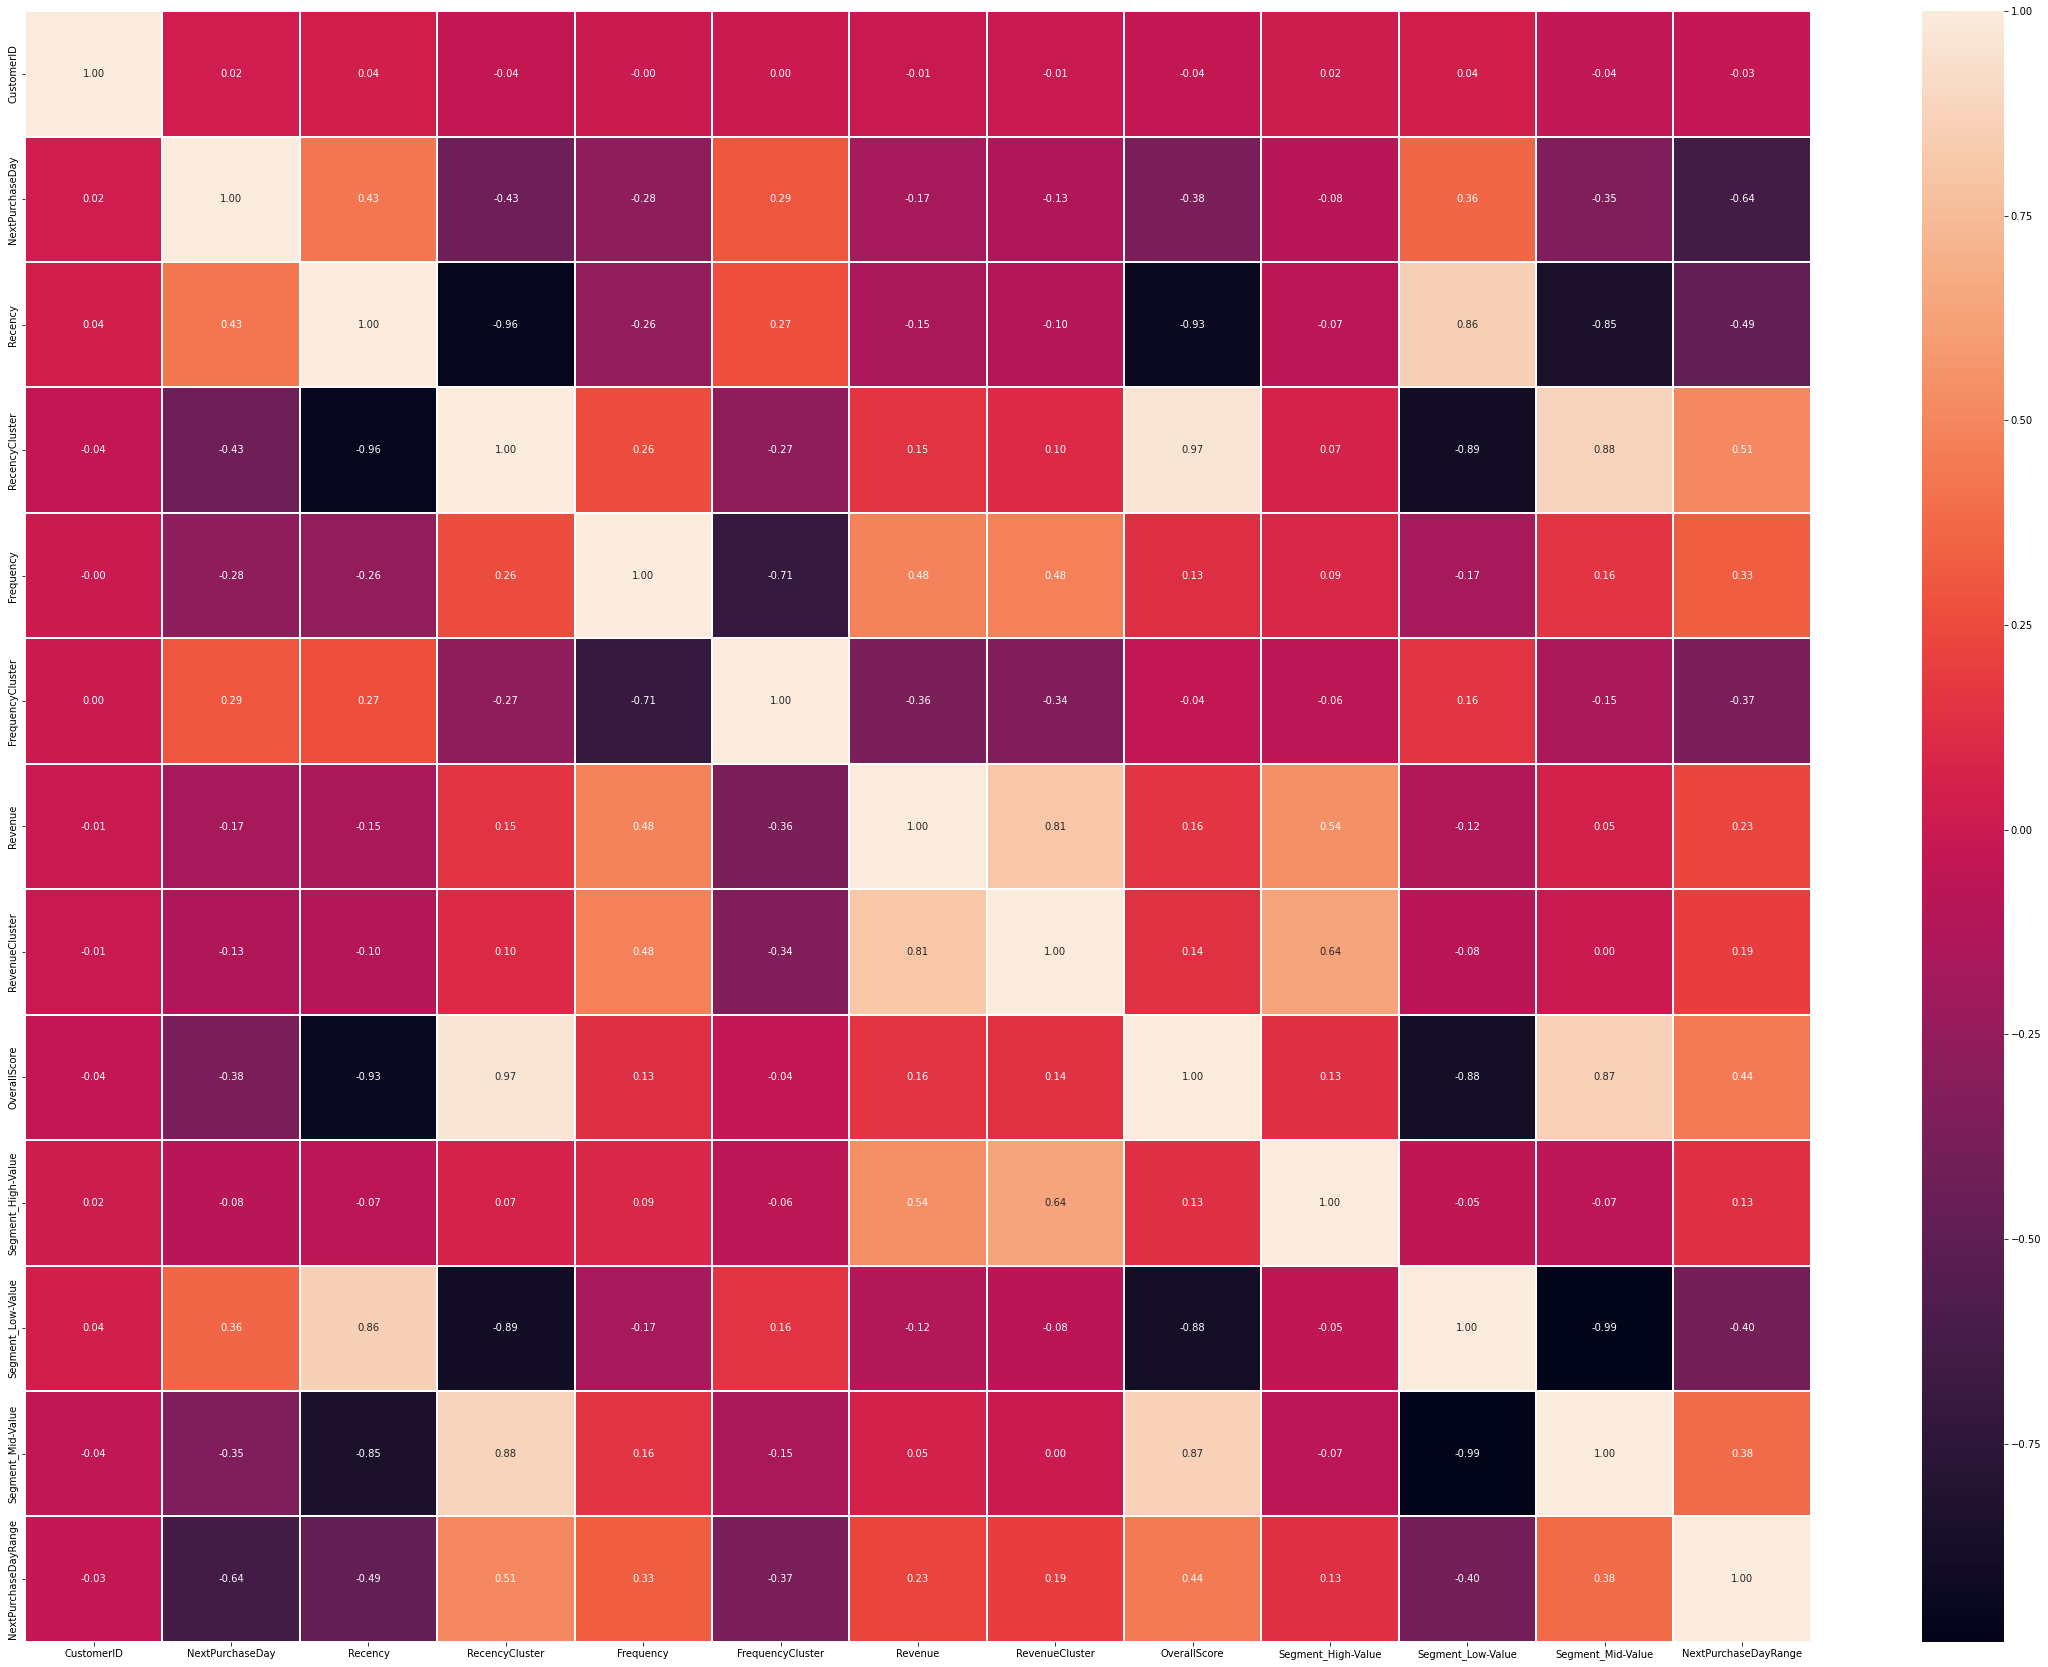

In [59]:
plt.figure(figsize = (40, 30))
sns.heatmap(corr_matrix, annot = True, linewidths=0.2, fmt=".2f");

### Building Machine Learning Models

In [60]:
ctm_class = ctm_class.drop('NextPurchaseDay', axis=1)

In [61]:
ctm_class

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value,NextPurchaseDayRange
0,13085.0,57,3,92,3,1459.46,0,6,0,0,1,0
1,18087.0,44,3,95,3,14411.62,0,6,0,0,1,1
2,17519.0,33,3,190,3,4411.48,0,6,0,0,1,0
3,12362.0,12,3,242,3,4804.39,0,6,0,0,1,1
4,15712.0,9,3,156,3,3261.01,0,6,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5309,16684.0,33,3,717,2,134907.47,2,7,1,0,0,1
5310,12415.0,13,3,963,2,137913.89,2,7,1,0,0,1
5311,17450.0,0,3,389,2,211060.52,2,7,1,0,0,1
5312,14156.0,14,3,4026,1,289744.44,2,6,0,0,1,1


In [62]:
X, y = ctm_class.drop('NextPurchaseDayRange', axis=1), ctm_class.NextPurchaseDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None, shuffle=True)

In [63]:
# Create an array of models
models = []
models.append(("LogisticRegression", LogisticRegression()))
models.append(("GaussianNB", GaussianNB()))
models.append(("RandomForestClassifier", RandomForestClassifier()))
models.append(("SVC", SVC()))
models.append(("DecisionTreeClassifier", DecisionTreeClassifier()))
models.append(("xgb.XGBClassifier", xgb.XGBClassifier(eval_metric='mlogloss')))
models.append(("KNeighborsClassifier", KNeighborsClassifier()))

In [64]:
for name,model in models:
    kfold = KFold(n_splits=2)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result)

LogisticRegression [0.89840075 0.88517647]
GaussianNB [0.88805268 0.84611765]
RandomForestClassifier [0.90028222 0.87294118]
SVC [0.85324553 0.83482353]
DecisionTreeClassifier [0.87347131 0.85458824]
xgb.XGBClassifier [0.88381938 0.86823529]
KNeighborsClassifier [0.84524929 0.82070588]


In [65]:
rf_model = RandomForestClassifier().fit(X_train, y_train)

print('Accuracy of Random Forest classifier on training set: {:.2f}'
       .format(rf_model.score(X_train, y_train)))
print('Accuracy of Random Forest classifier on test set: {:.2f}'
       .format(rf_model.score(X_test[X_train.columns], y_test)))
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

Accuracy of Random Forest classifier on training set: 1.00
Accuracy of Random Forest classifier on test set: 0.90
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       875
           1       0.70      0.77      0.74       188

    accuracy                           0.90      1063
   macro avg       0.83      0.85      0.84      1063
weighted avg       0.91      0.90      0.90      1063



In [66]:
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

[15:12:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGB classifier on training set: 1.00
Accuracy of XGB classifier on test set: 0.91
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       875
           1       0.72      0.79      0.76       188

    accuracy                           0.91      1063
   macro avg       0.84      0.86      0.85      1063
weighted avg       0.91      0.91      0.91      1063



Let's see how we could improve the existing model XGB by finding suitable parameters via the process of hyperparameter tuning using GridSearchCV.

In [67]:
parameter = {
    'max_depth':range(3,10,2), 
    'min_child_weight':range(1,5,2)
    }

p_grid_search = GridSearchCV(estimator = xgb.XGBClassifier(eval_metric='mlogloss'), 
                             param_grid = parameter, 
                             scoring='accuracy', 
                             n_jobs=-1, 
                             #iid=False, 
                             cv=2
                            )

p_grid_search.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
         

In [68]:
p_grid_search.best_params_, p_grid_search.best_score_

({'max_depth': 3, 'min_child_weight': 3}, 0.8814383266006308)

In [69]:
refined_xgb_model = xgb.XGBClassifier(eval_metric='logloss', 
                                      max_depth=list(p_grid_search.best_params_.values())[0]-1, 
                                      min_child_weight=list(p_grid_search.best_params_.values())[-1]+4
                                     ).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'.format(refined_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'.format(refined_xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.92
Accuracy of XGB classifier on test set: 0.92


In [77]:
ref_xgb_pred_y = refined_xgb_model.predict(X_test)

In [76]:
#Merge predictions to original data 
ref_xgb_pred_y = refined_xgb_model.predict(X)

ctm_class['predictions'] = ref_xgb_pred_y

ctm_class_final = ctm_class[['CustomerID', 'predictions']]
ctm_class_final

,CustomerID,predictions
0,13085.0,0
1,18087.0,1
2,17519.0,1
3,12362.0,1
4,15712.0,1
...,...,...
5309,16684.0,1
5310,12415.0,1
5311,17450.0,1
5312,14156.0,1


In [72]:
#ctm_class_final.to_csv("./submission.csv")

### Plot confusion matrix

In [73]:
def get_confusion_matrix(y_test, y_pred):
    """
    Displays the confusion matrix of the input numpy arrays y_test and y_pred.
    
    INPUT: 
        y_test - A numpy array 
        y_pred - A numpy array
        
    OUTPUT:
        NoneType
    """
    
    data = {'y_Actual': y_test, 'y_Predicted': y_pred}

    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    conf_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], 
                              rownames=['Actual'], 
                              colnames=['Predicted'])
    
    sns.heatmap(conf_matrix, annot=True, fmt = "d", cmap="Spectral")
    plt.show()

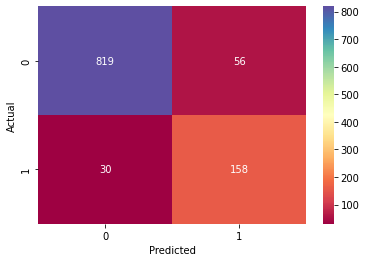

In [78]:
get_confusion_matrix(np.array(y_test), ref_xgb_pred_y)

### Plot AUC Curve

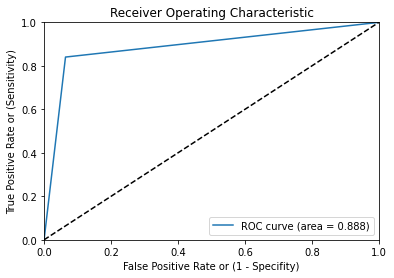

In [79]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, ref_xgb_pred_y)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")